In [1]:
using Pkg
Pkg.activate("../")

using Base.Filesystem

# This is to read wav files.
# See: https://github.com/dancasimiro/WAV.jl
using WAV
using Plots
pyplot()

using Revise
using SpeechFeatures

 Activating environment at `~/GithubRepositories/SpeechFeatures/Project.toml`
┌ Info: Precompiling SpeechFeatures [6f3487c4-5ca2-4050-bfeb-2cf56df92307]
└ @ Base loading.jl:1260


Download an example audio file from the TIMIT 
corpus.

In [3]:
if ! isfile("LDC93S1.wav")
    run(`wget https://catalog.ldc.upenn.edu/desc/addenda/LDC93S1.wav`)
end

Load the audio file

sampling freq: 16000.0 Hz
duration: 2.92 s


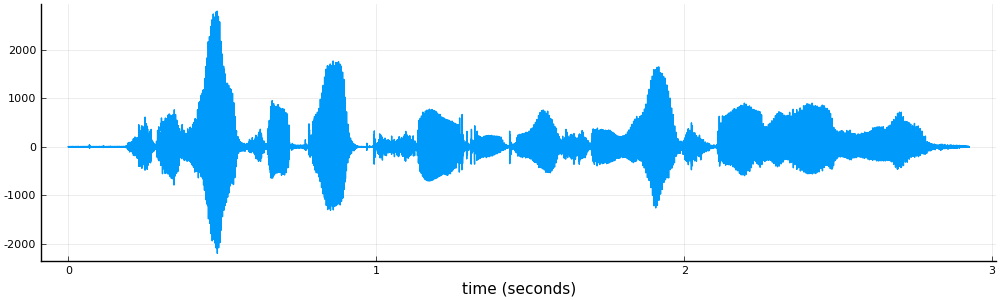

In [4]:
# The "native" option get the data in int16 type. 
# Reading the data in "double" format maybe cause 
# some problems later with the "dithering" parameter.
channels, srate = wavread("LDC93S1.wav", format="double")
channels *= typemax(Int16)


# TIMIT data has only one channel (i.e. "mono") 
x = channels[:, 1]

println("sampling freq: $srate Hz\nduration: $(round(length(x) / srate, digits=2)) s")

t = range(0, length(x) / srate, length=length(x))
plot(t, x, size=(1000, 300), xlabel="time (seconds)", legend = false)

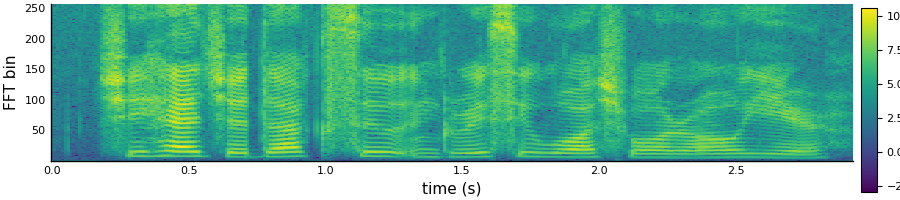

In [9]:
lms = LogMagnitudeSpectrum(
    fftlen = fftlen_auto,
    srate = 16000,
    frameduration = 0.025,
    framestep = 0.01,
    removedc = true,
    preemphasis = 0.97,
    dithering = 0.,
    windowfn = hann,
    windowpower = 1.0
)
fea = x |> lms

heatmap(
    Vector(range(0, length(x) / srate, length=size(fea, 2))),
    1:size(fea, 1),
    fea,
    size = (900, 200),
    xlabel = "time (s)",
    ylabel = "FFT bin",
    c = :viridis
)

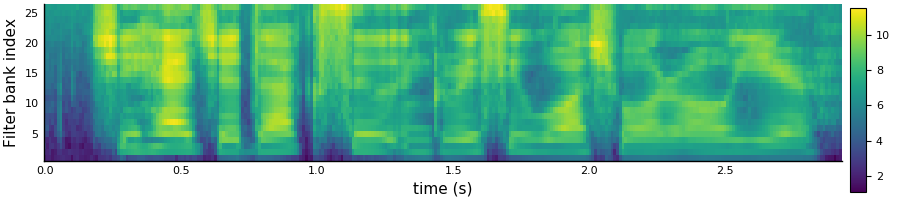

In [10]:
logfbank = LogMelSpectrum(
    fftlen = fftlen_auto,
    srate = 16000,
    frameduration = 0.025,
    framestep = 0.01,
    removedc = true,
    preemphasis = 0.97,
    dithering = 0.,
    windowfn = hann,
    windowpower = 1.0,
    nfilters = 26,
    lofreq = 80,
    hifreq = 8000
)
fea = x |> logfbank

heatmap(
    Vector(range(0, length(x) / srate, length=size(fea, 2))),
    1:size(fea, 1),
    fea,
    size = (900, 200),
    xlabel = "time (s)",
    ylabel = "Filter bank index",
    c = :viridis
)

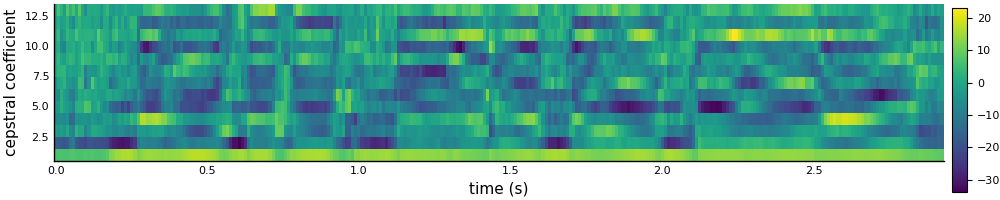

In [11]:
mfcc = MFCC(
    T = Float32, # Default is Float64
    fftlen = fftlen_auto,
    srate = 16000,
    frameduration = 0.025,
    framestep = 0.01,
    removedc = true,
    preemphasis = 0.97,
    dithering = 0.,
    windowfn = hann,
    windowpower = 0.85,
    nfilters = 26,
    lofreq = 80,
    hifreq = 8000,
    nceps = 12,
    liftering = 22,
    htkscaling = true,
    energy = rawenergy,
    energyfloor = 0.,
)
fea = x |> mfcc

heatmap(
    range(0, length(x) / srate, length=size(fea, 2)),
    1:size(fea, 1),
    fea,
    size = (1000, 200),
    xlabel = "time (s)",
    ylabel = "cepstral coefficient",
    c=:viridis
)

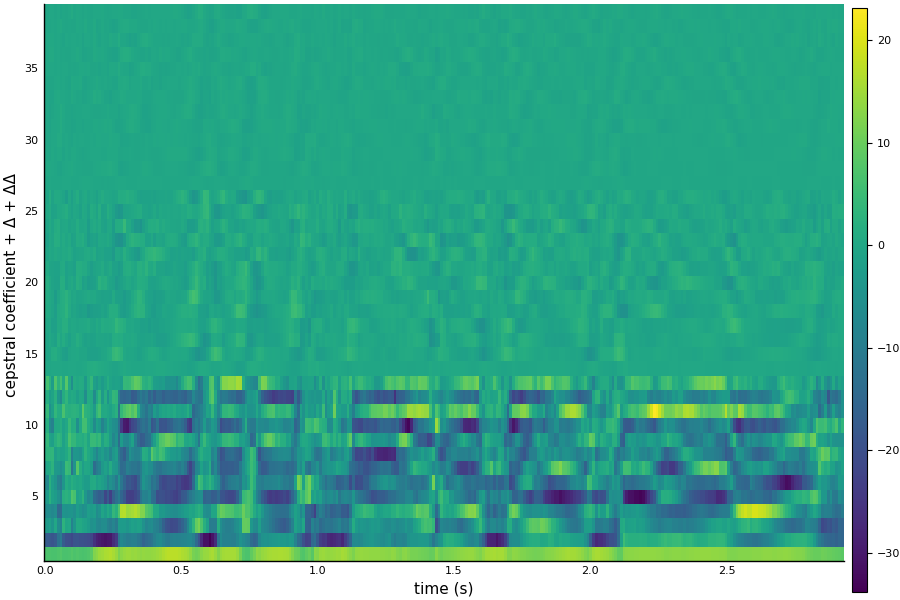

In [12]:
Δ_ΔΔ = DeltaCoeffs(
    order = 2, 
    win = 2
)
fea_Δ_ΔΔ = fea |> Δ_ΔΔ

heatmap(
    Vector(range(0, length(x) / srate, length=size(fea_Δ_ΔΔ, 2))),
    1:size(fea_Δ_ΔΔ, 1),
    fea_Δ_ΔΔ,
    size = (900, 600),
    xlabel = "time (s)",
    ylabel = "cepstral coefficient + Δ + ΔΔ ",
    c=:viridis
)